# Kaggle: Housing Prices Competition

Entry for the Kaggle Housing Prices Competition.  Given a set of historical data on housing sale prices, predict the sale price of a home.

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Load Data

Load train and test data.

In [2]:
# iowa_file_path = '../input/train.csv'  # competition data
iowa_file_path = 'data/train.csv'  # local data
df_train = pd.read_csv(iowa_file_path)

# test_data_path = '../input/test.csv'
test_data_path = 'data/test.csv'
df_test = pd.read_csv(test_data_path)

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## EDA

Explore the data.

### Shape

We have 81 dimensions (features) and 1460 entries (rows).

In [3]:
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


### Dtypes

We have int64's, floats, and objects.  We'll need to take a closer look at those objects.  They may be misclassified (can convert to numeric) or they may be categorical.  

In [4]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [5]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Target

Let's take a look at our target (dependent variable).

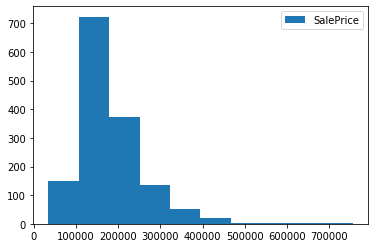

In [6]:
plt.hist(df_train['SalePrice'], label='SalePrice')
plt.legend()
plt.show()

### Compare Feature to Target

Pick a feature that should be somewhat correlated to the target value and create a scatter plot to see how linear the relationship might be.

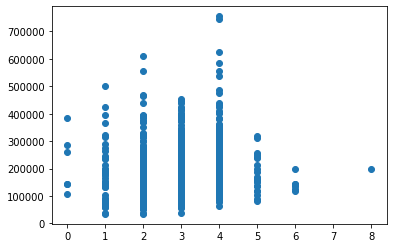

In [7]:
plt.scatter(df_train['BedroomAbvGr'], df_train['SalePrice'])
plt.show()

#### Add Best Fit Line

For reference, let's do a simple 1D linear regression and display the best fit line on the plot.

In [8]:
# define a function we can use to examine other features as well
# 1D linear regression
def linear_regression_plot(X, y, label=None):
    denominator = X.dot(X) - X.mean() * X.sum()
    a = ( X.dot(y) - y.mean()*X.sum() ) / denominator
    b = ( y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

    # let's calculate the predicted Y
    test_preds = a*X + b

    # let's plot everything together to make sure it worked
    # plt.scatter(X, y)
    # plt.plot(X, test_preds)
    # plt.show()
    
    fig = plt.figure()
    fig.subplots_adjust(top=0.8)
    ax1 = fig.add_subplot(211)
    ax1.set_ylabel('SalePrice')
    if label:
        ax1.set_title(label)
    ax1.scatter(X, y)
    ax1.plot(X, test_preds, color='r')
    
    ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.3])
    ax2.hist(X)
    ax2.set_xlabel('hist')
    
    plt.show()
    
    val_mae = mean_absolute_error(test_preds, y)
    print("Validation MAE for {}: {:,.0f}".format(label, val_mae))

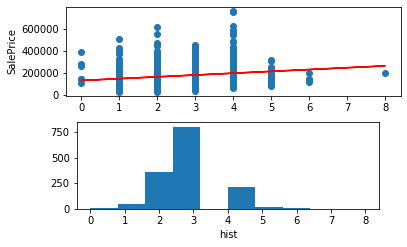

Validation MAE for None: 56,420


In [9]:
linear_regression_plot(df_train['BedroomAbvGr'], df_train['SalePrice'])

### Plot Features

Let's take a look at the plots of some other features of interest.

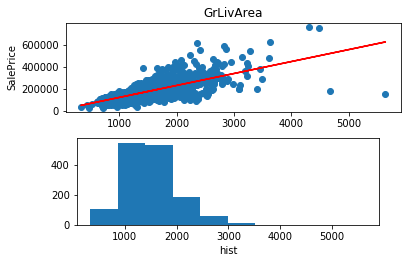

Validation MAE for GrLivArea: 37,639


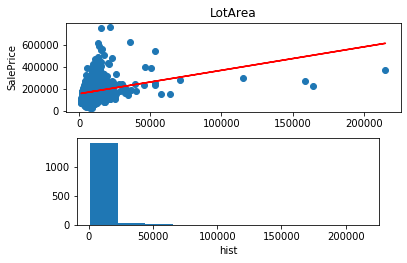

Validation MAE for LotArea: 55,122


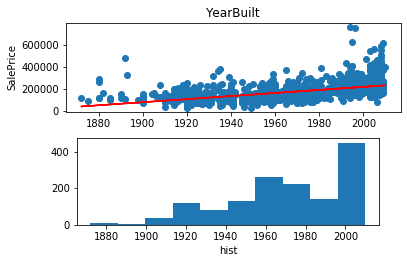

Validation MAE for YearBuilt: 47,024


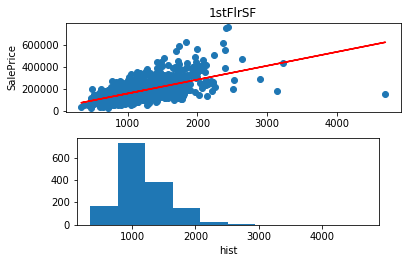

Validation MAE for 1stFlrSF: 46,242


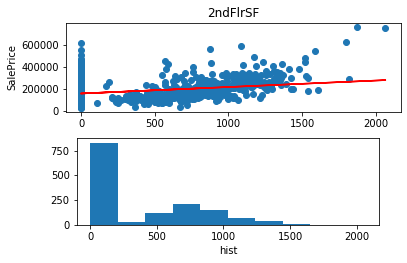

Validation MAE for 2ndFlrSF: 53,849


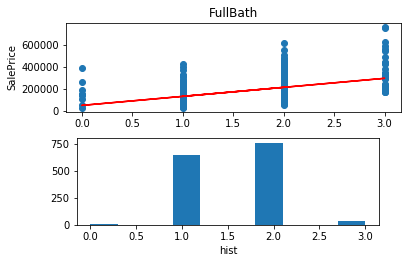

Validation MAE for FullBath: 44,926


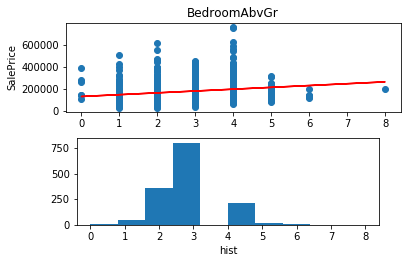

Validation MAE for BedroomAbvGr: 56,420


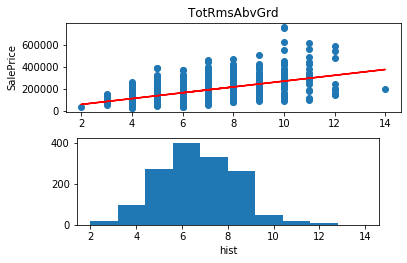

Validation MAE for TotRmsAbvGrd: 47,387


In [10]:
# let's take a look at all the features we might be interested in
features = ['GrLivArea', 'LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

for feature in features:
    linear_regression_plot(df_train[feature], df_train['SalePrice'], label=feature)

## Data Pre-Processing

Get the data ready for ML.

In [11]:
# drop rows without a sale price
df_train = df_train.dropna(axis=0, subset=['SalePrice'])

In [12]:
# remove the logical outlier of a large house with low price
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index)

In [13]:
# let's take the log of the target, log(1+x)
# df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

# plt.hist(df_train['SalePrice'], label='SalePrice')
# plt.legend()
# plt.show()

In [14]:
# fill missing values
obj_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
                'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType',
                'MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual',
                'Functional', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'CentralAir']

# obj_features = df.select_dtypes(include=['object'])
for feature in obj_features:
    df_train[feature] = df_train[feature].fillna("None")
    df_test[feature] = df_test[feature].fillna("None")

numeric_features = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                   'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

# numeric_features = df.select_dtypes(exclude=['object'])
for feature in numeric_features:
    df_train[feature] = df_train[feature].fillna(0)
    df_test[feature] = df_test[feature].fillna(0)

### Categories

Convert some of the object fields to str categories.

In [15]:
category_features = ['OverallCond', 'YrSold', 'MoSold', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 
                     'GarageCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
                     'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
                     'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass']

for feature in category_features:
    df_train[feature] = df_train[feature].astype(str)
    label = LabelEncoder()
    label.fit(list(df_train[feature].values))
    df_train[feature] = label.transform(list(df_train[feature].values))

for feature in category_features:
    df_test[feature] = df_test[feature].astype(str)
    label = LabelEncoder()
    label.fit(list(df_test[feature].values))
    df_test[feature] = label.transform(list(df_test[feature].values))
    
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,9,RL,65.0,8450,1,1,3,Lvl,AllPub,...,0,3,4,None,0,4,2,WD,Normal,208500
1,2,4,RL,80.0,9600,1,1,3,Lvl,AllPub,...,0,3,4,None,0,7,1,WD,Normal,181500
2,3,9,RL,68.0,11250,1,1,0,Lvl,AllPub,...,0,3,4,None,0,11,2,WD,Normal,223500
3,4,10,RL,60.0,9550,1,1,0,Lvl,AllPub,...,0,3,4,None,0,4,0,WD,Abnorml,140000
4,5,9,RL,84.0,14260,1,1,0,Lvl,AllPub,...,0,3,4,None,0,3,2,WD,Normal,250000


### Skewness

Some of the data is a bit skewed.  Let's try to correct that.

In [16]:
skewed_features = df_train[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features_test = df_test[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew': skewed_features})
skewness = skewness[abs(skewness) > 0.75]

skewness_test = pd.DataFrame({'Skew': skewed_features_test})
skewness_test = skewness_test[abs(skewness_test) > 0.75]

print(skewness.shape)
skewness

(10, 1)


,Skew
BsmtFinSF2,4.247550
BsmtHalfBath,4.095895
MasVnrArea,2.693554
BsmtUnfSF,0.919955
BsmtFinSF1,0.764002
BsmtFullBath,NaN
TotalBsmtSF,NaN
GarageArea,NaN
GarageCars,NaN
GarageYrBlt,-3.862401


In [17]:
skewed_features = skewness.index
lam = 0.15
for feature in skewed_features:
    df_train[feature] = boxcox1p(df_train[feature], lam)
    
skewed_features_test = skewness_test.index
for feature in skewed_features_test:
    df_test[feature] = boxcox1p(df_test[feature], lam)

In [18]:
# explode the categories into 1s, 0s    
# df_train = pd.get_dummies(df_train)
# df_test = pd.get_dummies(df_test)

print(df_train.shape)
df_train.head()

(1458, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,9,RL,65.0,8450,1,1,3,Lvl,AllPub,...,0,3,4,None,0,4,2,WD,Normal,208500
1,2,4,RL,80.0,9600,1,1,3,Lvl,AllPub,...,0,3,4,None,0,7,1,WD,Normal,181500
2,3,9,RL,68.0,11250,1,1,0,Lvl,AllPub,...,0,3,4,None,0,11,2,WD,Normal,223500
3,4,10,RL,60.0,9550,1,1,0,Lvl,AllPub,...,0,3,4,None,0,4,0,WD,Abnorml,140000
4,5,9,RL,84.0,14260,1,1,0,Lvl,AllPub,...,0,3,4,None,0,3,2,WD,Normal,250000


## ML

Time for some ML.  XGBoost is the model that has worked best for this data so far.

In [19]:
y = df_train['SalePrice']
X = df_train.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
print(X.shape)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25)
X.head()

(1458, 59)


,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold
0,1,9,65.0,8450,1,1,3,0,7,4,...,61,0,0,0,0,3,4,0,4,2
1,2,4,80.0,9600,1,1,3,0,6,7,...,0,0,0,0,0,3,4,0,7,1
2,3,9,68.0,11250,1,1,0,0,7,4,...,42,0,0,0,0,3,4,0,11,2
3,4,10,60.0,9550,1,1,0,0,7,4,...,35,272,0,0,0,3,4,0,4,0
4,5,9,84.0,14260,1,1,0,0,8,4,...,84,0,0,0,0,3,4,0,3,2


In [20]:
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
val_X = my_imputer.transform(val_X)

my_model = XGBRegressor(n_estimators=170, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5,
             eval_set=[(val_X, val_y)], verbose=False)

# create predictions
val_preds = my_model.predict(val_X)
val_mae = mean_absolute_error(val_preds, val_y)
print("Validation MAE for xgboost: {:,.0f}".format(val_mae))

Validation MAE for xgboost: 14,870


## Submission

Create the final model using all the data and submission file.

In [21]:
# create a new model based on all the training data
my_model = XGBRegressor(n_estimators=170, learning_rate=0.05)
my_model.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=170, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [22]:
# test_X with the dimensions we chose for our model
val_X = df_test.select_dtypes(exclude=['object'])

# create predictions
val_preds = my_model.predict(val_X)

output = pd.DataFrame({'Id': df_test.Id, 
                       'SalePrice': val_preds})
output.to_csv('submission.csv', index=False)

## Results

Final Score:

- MAE: 16000
- Rank: Top 10% (3180 out of 29990)

2020